In [45]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import pandas as pd
import pprint
import os
import re

from os import listdir, getcwd

# Disable scientific notation
pd.set_option("display.float_format", "{:.2f}".format)

### Preparing the Dataset

In [3]:
# Getting file path list of each month extracted data
cwd = os.getcwd()
path = f"{cwd}/fipe-webscraping/extracted-data/raw-data/"
data_files = [path + file for file in listdir(path)]

# Concatenate each month data into a single data frame
fipe_data = pd.concat(map(lambda f: pd.read_csv(f, on_bad_lines='skip'), data_files))
fipe_data

,fipe_cod,tabela_id,anoref,mesref,tipo,marca_id,marca,modelo_id,modelo,anomod,comb_cod,comb_sigla,comb,valor
0,008021-7,309,2024,5,1,6,Audi,78,A4 2.4 30V Avant Tip./Multitronic,1998,1,G,Gasolina,22271
1,008154-0,309,2024,5,1,6,Audi,5549,A7 Sportback 3.0 TFSI Quattro S Tronic,2013,1,G,Gasolina,151731
2,008062-4,309,2024,5,1,6,Audi,126,A8 4.2 Quattro Tiptronic,2005,1,G,Gasolina,154789
3,008014-4,309,2024,5,1,6,Audi,127,A8 4.2 V8 32V Tiptronic,1995,1,G,Gasolina,27032
4,008242-2,309,2024,5,1,6,Audi,8628,RS4 2.9 Avant V6 TFSI Quattro Tiptronic,2021,1,G,Gasolina,580439
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
254,046001-0,318,2025,2,1,27,Isuzu,1348,Amigo 2.3 4x2/4x4,1994,1,G,Gasolina,9012
255,046001-0,318,2025,2,1,27,Isuzu,1348,Amigo 2.3 4x2/4x4,1993,1,G,Gasolina,7477
256,046001-0,318,2025,2,1,27,Isuzu,1348,Amigo 2.3 4x2/4x4,1992,1,G,Gasolina,6599
257,046002-8,318,2025,2,1,27,Isuzu,1349,Hombre 2 WD XS 2.2,1998,1,G,Gasolina,12021


In [4]:
fipe_data[['modelo','anomod']].value_counts()

modelo                                    anomod
Corsa Sed Class.Super 1.0/1.0 FlexPower   2005      2
Corsa Sed.Wind 1.0/Millenium/Classic VHC  2002      2
F-1000 CD/Blazer 3.6                      1995      2
Escort Ghia 2.0i / 2.0                    1995      2
Fiorino Furgão 1.0                        1996      2
                                                   ..
iX XDrive 40 Aut. (Elétrico)              2024      1
iX XDrive 50 Sport Aut. (Elétrico)        2022      1
ix35 2.0 16V 2WD Flex Aut.                2019      1
ix35 GLS 2.0 16V 2WD Flex Aut.            2013      1
125i M Sport/Active Flex 2.0 TB Aut. 5p   2014      1
Name: count, Length: 4692, dtype: int64

### Understanding the Value Column ('valor')

In [5]:
# Convert 'valor' column to float
fipe_data['valor'] = fipe_data['valor'].astype(float)

# Generate statistics about 'valor' column
valor_stats = fipe_data['valor'].describe()

# Count of null values in 'valor' column
null_count = fipe_data['valor'].isnull().sum()

# Median of 'valor' column
valor_median = fipe_data['valor'].median()

# print the results
print(f"Statistics about 'valor' column:\n{valor_stats}")
print("\n")
print(f"Null values in 'valor' column: {null_count}")
print(f"Median of 'valor' column: {valor_median}")

Statistics about 'valor' column:
count      4713.00
mean     113478.88
std      331080.13
min        2317.00
25%       19796.00
50%       40981.00
75%       98510.00
max     6566975.00
Name: valor, dtype: float64


Null values in 'valor' column: 0
Median of 'valor' column: 40981.0


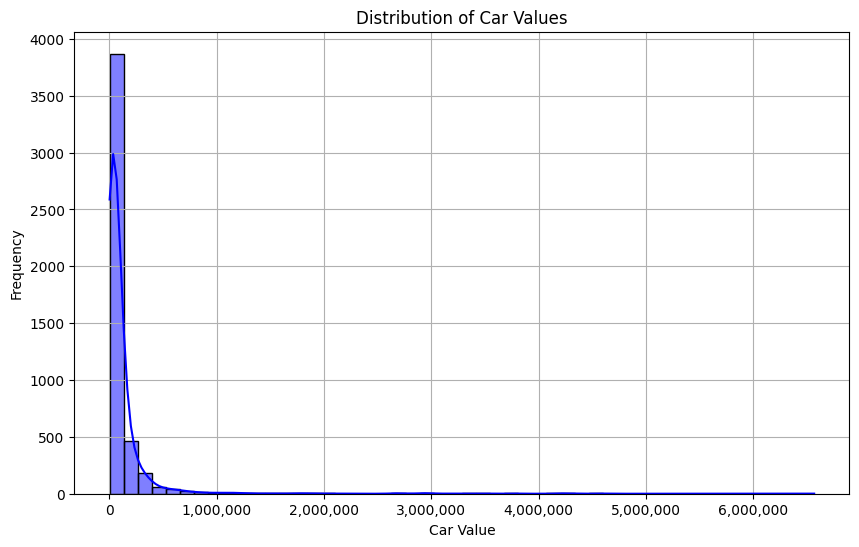

In [6]:
# Plotting the histogram of 'valor' column
plt.figure(figsize=(10, 6))
sns.histplot(fipe_data['valor'], bins=50, kde=True, color='blue')
plt.title("Distribution of Car Values")
plt.xlabel("Car Value")
plt.ylabel("Frequency")

# Adjusting x-axis to avoid scientific notation
plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{x:,.0f}'))

plt.grid(True)

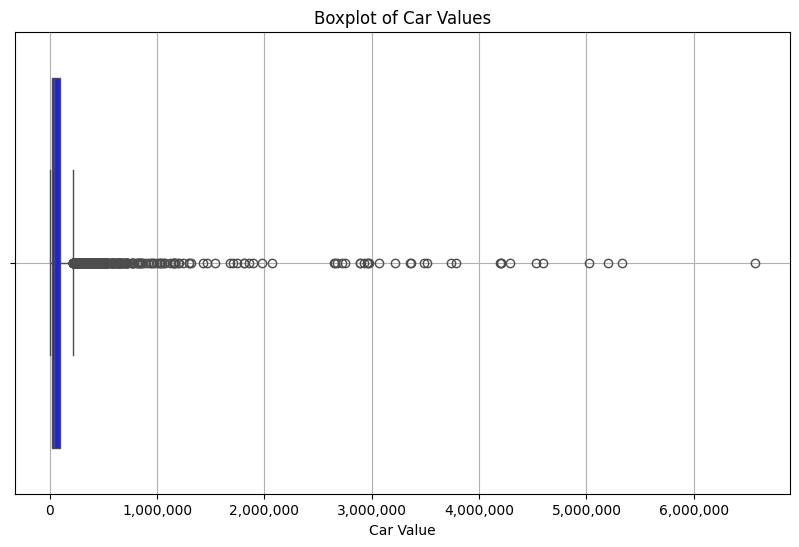

In [7]:
# Plotting the boxplot of 'valor' column
plt.figure(figsize=(10, 6))
sns.boxplot(x=fipe_data['valor'], color='blue')
plt.title("Boxplot of Car Values")
plt.xlabel("Car Value")

# Adjusting x-axis for boxplot
plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{x:,.0f}'))

plt.grid(True)

#### Visualizing Car Values Without Outliers

To improve the clarity of the visualizations and focus on the majority of the data, we decided to temporarily exclude outliers only in the visualizations. This allows us to better see the distribution of car values without affecting the underlying dataset.

We used the **Interquartile Range (IQR)** method to define the upper limit for values to be considered as outliers. Outliers are considered as values beyond 1.5 times the IQR above the third quartile or below the first quartile.

However, it is important to note that these outliers are not removed from the dataset itself, only from the visual representation, allowing us to focus on the typical car prices for more effective analysis and modeling.

- The **histogram** shows the distribution of car prices without the influence of outliers in the visualization.
- The **boxplot** helps to visualize the spread and central tendency of the data while excluding extreme values from the plot.



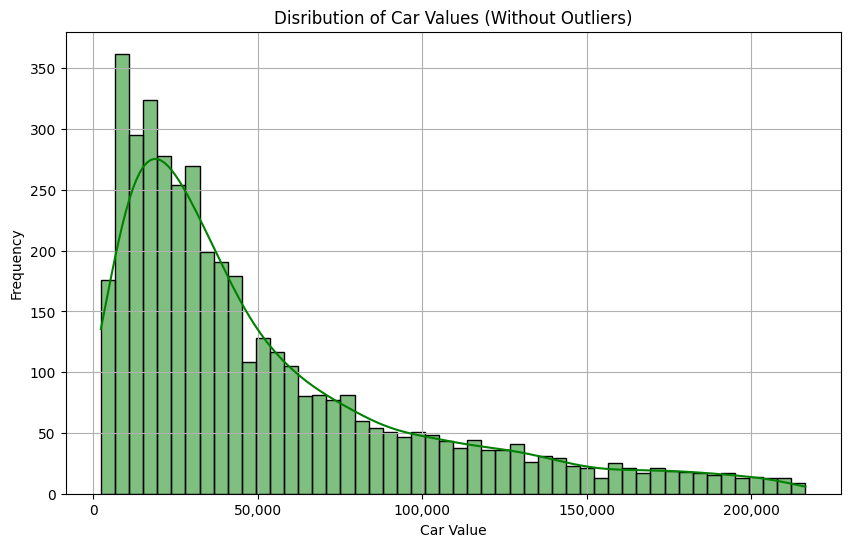

In [8]:
# Define the upper limit to trim outliers for visualization
upper_limit = fipe_data['valor'].quantile(0.75) + 1.5 * (fipe_data['valor'].quantile(0.75) - fipe_data['valor'].quantile(0.25))

# Filter the data only for visualization (do not modify the original dataset)
filtered_data_for_viz = fipe_data[fipe_data['valor'] <= upper_limit]

# Plotting the histogram of 'valor' column without outliers
plt.figure(figsize=(10, 6))
sns.histplot(filtered_data_for_viz['valor'], bins=50, kde=True, color='green')
plt.title('Disribution of Car Values (Without Outliers)')
plt.xlabel('Car Value')
plt.ylabel('Frequency')

# Adjusting x-axis to avoid scientific notation
plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{x:,.0f}'))

plt.grid(True)


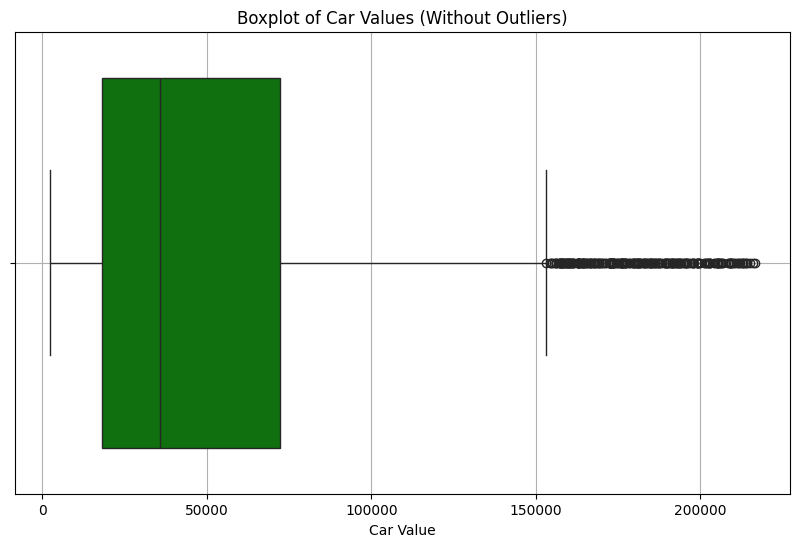

In [9]:
# Plotting the boxplot of 'valor' column without outliers
plt.figure(figsize=(10, 6))
sns.boxplot(x=filtered_data_for_viz['valor'], color='green')
plt.title('Boxplot of Car Values (Without Outliers)')
plt.xlabel('Car Value')

plt.grid(True)

### Extract additional features from the Model Column ('modelo')

In [35]:
fipe_data['modelo'].sample(50)

276                  F458 Italia F1 4.5 V8 570cv
225              UNO WAY 1.4 EVO Fire Flex 8V 2p
800                   Fiorino Pick-Up LX (todas)
385                   X5 Security 4.4 4x4 V8 32V
636                Jumper 2.0 FurgãoTurbo Diesel
595     Ranger XL 3.0 PSE 163cv 4x2 CD TB Diesel
935             EcoSport SE 1.6 16V Flex 5p Mec.
154        Ranger Limited 3.2 4x4 CD Diesel Aut.
227              UNO WAY 1.4 EVO Fire Flex 8V 5p
1424          S-63 L AMG 6.2 V8/5.5 V8 Bi-TB Aut
2                                 A3 1.6 3p Aut.
18                   A4 2.4 30V Tip./Multitronic
187      A6 Allroad 3.0 TFSI V6 Quattro S tronic
170                            Buggy Plus 1.6 8V
25                   A6 2.4 30V Tip./Multitronic
68                  C5 Exclusive 2.0 16V 4p Aut.
652      Celta Life/ LS 1.0 MPFI 8V FlexPower 3p
683                    Xsara GLX 1.6 16V 5p Mec.
581                  Ranger 2.5 4x4 CD TB Diesel
374         Civic Sedan EX 1.7 16V 130cv Aut. 4p
322      ONIX SEDAN 

In [73]:
def extract_features_from_modelo(modelo: str) -> pd.Series:
    """
    Extract version, engine type, and car category from the 'modelo' column.
    Also strips leading and trailing spaces and classifies engine type and car category.

    Parameters:
    - modelo: str: The car model description.

    Returns:
    - pd.Series: A pandas Series with three values: version, engine type, and car category.
    """
    
    # Strip leading and trailing spaces
    modelo = modelo.strip()
    
    # Extracting version (e.g., "1.8", "2.0", "16V", "1.6/16V", etc.)
    version_pattern = r'(\d+\.\d+|\d{1,2}(\.\d+)?(?:\/\d+)?(?: [A-Za-z]+)?)'
    
    # Extracting engine type (e.g., "Flex", "Diesel", "Turbo", "V6", "8V", "16V", etc.)
    engine_pattern = r'(V\d+|Eletric|Flex|Gasolina|Diesel|Turbo|V6|16V|8V|12V|MPFI|Bi-Turbo|GDI|CV)'
    
    # Extracting car category (e.g., "Hatch", "Sedan", "SUV", "Picape", "Crossover", etc.)
    category_pattern = r'(SUV|Hatch|Sedan|Picape|Pickup|Wagon|Crossover|Avant|MPV|4x4|Sport|Luxury|Coupe|Convertible)'
    
    # Extract version
    version = re.findall(version_pattern, modelo)
    version = version[0][0] if version else None

    # Extract engine type and clean up (strip spaces)
    engine = re.findall(engine_pattern, modelo)
    engine = engine[0].strip() if engine else None

    # Extract car category
    category = re.findall(category_pattern, modelo)
    category = category[0].strip() if category else None
    
    # Classify engine type based on keywords
    def classify_engine_type(engine: str) -> str:
        if engine:
            engine = engine.strip().lower()
            if 'turbo' in engine:
                return 'Turbo'
            elif 'flex' in engine:
                return 'Flex'
            elif 'diesel' in engine:
                return 'Diesel'
            elif 'electric' in engine or 'eletric' in engine:
                return 'Electric'
            elif 'v6' in engine or 'v8' in engine:
                return 'V6/V8'
            else:
                return 'Other'
        return None

    # Classify car category based on keywords
    def classify_category(category: str) -> str:
        if category:
            category = category.strip().lower()
            if 'suv' in category:
                return 'SUV'
            elif 'hatch' in category:
                return 'Hatchback'
            elif 'sedan' in category:
                return 'Sedan'
            elif 'picape' in category or 'pickup' in category:
                return 'Pickup'
            elif 'crossover' in category:
                return 'Crossover'
            elif 'wagon' in category:
                return 'Wagon'
            elif 'luxury' in category:
                return 'Luxury'
            elif 'coupe' in category:
                return 'Coupe'
            elif 'convertible' in category:
                return 'Convertible'
            elif 'sport' in category:
                return 'Sport'
            elif 'mpv' in category or 'avant' in category:
                return 'MPV'
            else:
                return 'Other'
        return None

    # Classify engine type and car category
    engine_type = classify_engine_type(engine)
    car_category = classify_category(category)

    return pd.Series([version, engine_type, car_category])

In [68]:
# Apply the function and create new columns in the DataFrame
fipe_data[['version', 'engine', 'category']] = fipe_data['modelo'].apply(extract_features_from_modelo)


In [69]:
# Verifying the new columns
fipe_data[['version', 'engine', 'category']].sample(5)

,version,engine,category
249,10,Diesel,None
209,1.4,Flex,None
846,2.1,Diesel,None
703,1.8,Other,Sport
134,4,V6/V8,MPV


In [70]:
# Prepare the report using describe for categorical columns
descriptive_report = fipe_data[['version', 'engine', 'category']].describe(include=[object])

# Calculate additional quality metrics
missing_values = fipe_data[['version', 'engine', 'category']].isnull().sum()
unique_values = fipe_data[['version', 'engine', 'category']].nunique()
mode_values = fipe_data[['version', 'engine', 'category']].mode().iloc[0]
most_frequent_counts = fipe_data[['version', 'engine', 'category']].apply(lambda x: x.value_counts().iloc[0])

# Combine the descriptive statistics with the additional metrics
descriptive_report.loc['missing'] = missing_values
descriptive_report.loc['unique'] = unique_values
descriptive_report.loc['mode'] = mode_values
descriptive_report.loc['most_frequent_count'] = most_frequent_counts

# Display the final report
pprint.pprint(descriptive_report)

                    version engine category
count                  4591   3192      905
unique                  286      5        9
top                     1.6  Other    Other
freq                    440   1205      308
missing                 122   1521     3808
mode                    1.6  Other    Other
most_frequent_count     440   1205      308


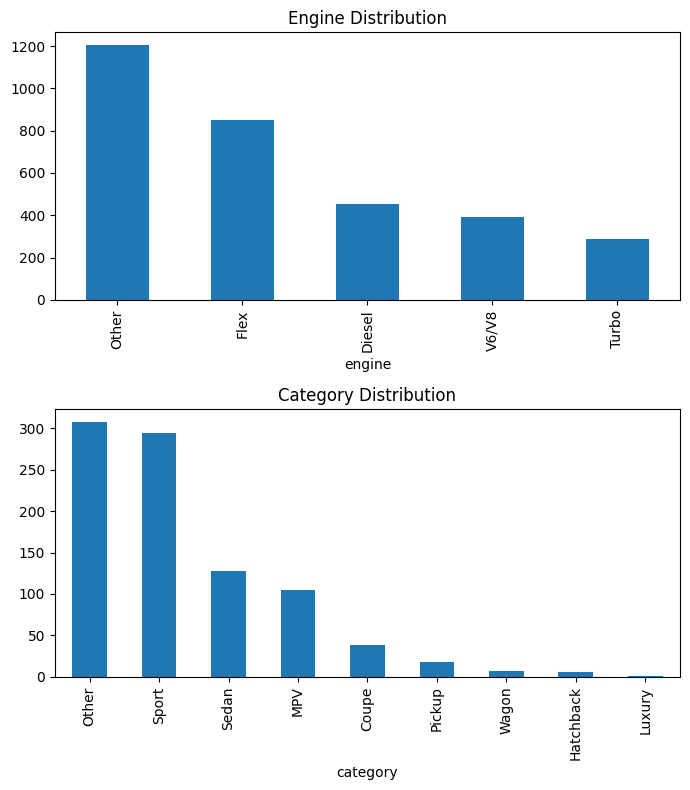

In [75]:
# Plot distribution of the'engine', and 'category' columns
fig, axes = plt.subplots(2, 1, figsize=(7, 8))

fipe_data['engine'].value_counts().plot(kind='bar', ax=axes[0], title='Engine Distribution')
fipe_data['category'].value_counts().plot(kind='bar', ax=axes[1], title='Category Distribution')

plt.tight_layout()

#### Analysis of the `version`, `engine`, and `category` columns

This section provides an overview of the distribution and quality of the new columns (`version`, `engine`, and `category`) based on the results from the dataset.

1. **`version` Column**
   - **Count**: There are 4,591 entries for the `version` column.
   - **Unique Values**: The `version` column contains 286 unique values, indicating a variety of car versions.
   - **Most Frequent Value**: The most common version is "1.6", which appears 440 times.
   - **Missing Values**: There are 122 missing values in the `version` column.
   - **Observations**: The `version` column contains a wide range of values, primarily numerical, possibly indicating engine sizes or version specifications for the vehicles.

2. **`engine` Column**
   - **Count**: The `engine` column contains 3,192 entries, suggesting that not all vehicles have a clearly defined engine type.
   - **Unique Values**: This column has 5 unique engine types. The most frequent engine type is "Other", which is observed 1,205 times. This indicates that a significant portion of the dataset lacks specific details about the engine or has generic data listed as "Other".
   - **Missing Values**: The `engine` column has 1,521 missing values, which is quite a large proportion, suggesting a lot of incomplete or undefined engine data.
   - **Observations**: The data in this column is sparse, with many entries categorized under the "Other" label. Further cleaning or standardization might be needed to provide more specific engine information.

3. **`category` Column**
   - **Count**: The `category` column has only 905 entries, making it significantly smaller than the other two columns.
   - **Unique Values**: There are 9 unique categories in this column, which could represent different types of vehicles such as "SUV", "Sedan", or "Hatch".
   - **Most Frequent Value**: The most common category is "Other", which appears 308 times, similarly to the `engine` column.
   - **Missing Values**: This column has 3,808 missing values, representing a large proportion of the dataset. This high number of missing entries suggests that category data is often not available for many vehicles.
   - **Observations**: Like the `engine` column, the `category` column also contains many missing values and instances of the "Other" category. This may require further refinement to improve the consistency and completeness of the data.
